<a href="https://colab.research.google.com/github/Murolando/analysis-of-a_b-testing-kwork/blob/main/a_b_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Задача: На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле ты найдешь сырые данные по результатам эксперимента (user_id), тип выборки (variant_name) и доход, принесенный пользователем (revenue).

Проанализируй результаты эксперимента и напиши свои рекомендации менеджеру.

Результат нужен в формате .ipynb файл, код на питоне с графиками и пр.

# Загрузка данных

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/ML Pr/Rabota 9 a b tests/AB_Test_Results.xlsx')

/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Анализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
len(df['USER_ID'].unique())

6324

In [ ]:
df['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Кол-во данных равно относительно классов, это значительно упрощает анализ

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

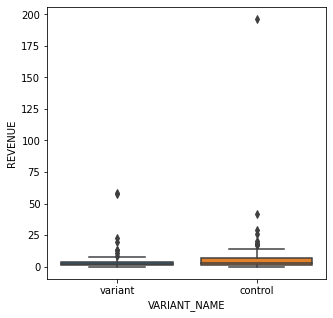

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(df.loc[df['REVENUE']>0],x = "VARIANT_NAME", y ='REVENUE')

In [ ]:
df.loc[(df['REVENUE']>0)].describe()

,USER_ID,REVENUE
count,152.000000,152.000000
mean,4862.217105,6.542566
std,2987.566745,17.706752
min,56.000000,0.020000
25%,2177.250000,1.250000
50%,4980.500000,2.420000
75%,7393.250000,4.607500
max,9996.000000,196.010000


In [ ]:
df.loc[(df['REVENUE']>0) & (df["VARIANT_NAME"] == 'variant')].describe()

,USER_ID,REVENUE
count,72.000000,72.000000
mean,5306.958333,4.881528
std,3116.544256,9.913973
min,56.000000,0.020000
25%,2707.500000,1.245000
50%,5721.000000,2.170000
75%,7963.750000,3.972500
max,9996.000000,58.630000


In [ ]:
df.loc[(df['REVENUE']>0) & (df["VARIANT_NAME"] != 'variant')].describe()

,USER_ID,REVENUE
count,80.000000,80.000000
mean,4461.950000,8.037500
std,2826.386242,22.498124
min,124.000000,0.020000
25%,2037.500000,1.515000
50%,4327.000000,2.960000
75%,6636.750000,6.657500
max,9766.000000,196.010000


Избавимся от единственного заметного выбросы

In [ ]:
df = df.loc[df['REVENUE']<196]

In [ ]:
df_variant = df.loc[(df['VARIANT_NAME'] == 'variant') & (0<df['REVENUE'])]
df_control = df.loc[(df['VARIANT_NAME'] != 'variant' ) & (0<df['REVENUE'])]

## Анализ экономических метрик


### Изменение количества покупок

In [ ]:
print(len(df_variant))
print(len(df_control))

72
79


### Суммарная выручка


In [ ]:
sum(df_control['REVENUE'])

446.9900000000001

In [ ]:
sum(df_variant['REVENUE'])

351.4700000000001

Вывод: суммарная выручка за месяц уменьшилась на почти 100 долларов

### Величина среднего чека

H0 - В ходе изменений на сайте величина среднего чека не изменилась

H1 - В ходе изменений на сайте величина среднего чека уменьшилась

Средний чек - выручки компании за конкретный период времени, например за месяц, делённая на количество покупок

In [ ]:
# variant
df_mean_check_varient = sum(df_variant['REVENUE'] / len(df_variant))
# control
df_mean_check_control = sum(df_control['REVENUE']) / len(df_control)
print(df_mean_check_varient,df_mean_check_control)

4.8815277777777775 5.658101265822786


<Axes: xlabel='REVENUE', ylabel='Count'>

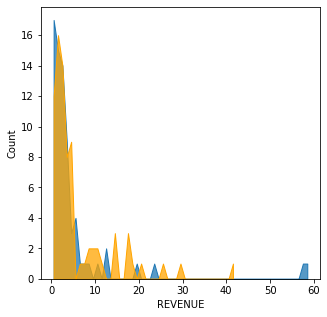

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(df_variant,x ='REVENUE',stat='count',binwidth=1,multiple="dodge",element ="poly")
sns.histplot(df_control,x ='REVENUE',stat='count',binwidth=1,multiple="dodge",element ="poly",color ='orange')

Вывод: Средний чек упал почти на 80 долларов, что также говорит не в пользу изменений

Но для полного вывода проверим статистическую значимость этого различия

Распределение отлично от нормального поэтому
Проверим верность гипотезы с помощью критерия Манна Уитни

In [ ]:
# variant
x = df_variant['REVENUE']
x.head(3)

13     2.15
139    4.27
149    1.75
Name: REVENUE, dtype: float64

In [ ]:
# control
y = df_control['REVENUE']
y.head(3)

49     3.25
152    2.99
333    9.91
Name: REVENUE, dtype: float64

In [ ]:
u1,p = stats.mannwhitneyu(x,y,method = 'exact',alternative = 'less')
u2 = len(x)*len(y) - u1
print(u1,u2,p)

2404.0 3284.0 0.05083135934993447


Конечно, порог в 0.05 уровня значимости не был преодолен, но я считаю, что для интернет магазина, недобор в 0.0008, не значителен => эти результаты следует отнести к статистически значимым => у нас есть основания отмести 0 гипотезу и принять альтернативную

### Конверсия
Конверсия - количество реальных клиентов на количество потенциальных и умножить на 100%

In [ ]:
df_conversion_variant = len(df_variant['REVENUE'])/len(df.loc[(df["VARIANT_NAME"] == 'variant')])
df_conversion_control = len(df_control['REVENUE'])/len(df.loc[(df["VARIANT_NAME"] != 'variant')])
print(df_conversion_control*100,df_conversion_variant*100)

1.5853903271121814 1.4354066985645932


Конверсия упала примерно на 0,15%, чтобы проверить значимость таких различий используем критерий Хи-квадрат

H0 - В ходе изменений на сайте величина конверсии не изменилась

H1 - В ходе изменений на сайте величина конверсии уменьшилась

Составляю таблицу сопряженности

In [ ]:
control_buy = len(df_control['REVENUE'])
control_nbuy = len(df.loc[(df["VARIANT_NAME"] != 'variant') & (df["REVENUE"] == 0) ])
variant_buy = len(df_variant['REVENUE'])
variant_nbuy = len(df.loc[(df["VARIANT_NAME"] == 'variant') & (df["REVENUE"] == 0) ])

In [ ]:

contingency_table = pd.DataFrame({'_':['Купили','Не купили','Total'],
                                  'Control':[control_buy,control_nbuy,control_buy+control_nbuy],
                                  'Variant':[variant_buy,variant_nbuy,variant_buy+variant_nbuy],
                                  'Total':[control_buy+variant_buy,control_nbuy+variant_nbuy,control_buy+control_nbuy+variant_buy+variant_nbuy]})


In [ ]:
contingency_table.head(5)

,_,Control,Variant,Total
0,Купили,79,72,151
1,Не купили,4904,4944,9848
2,Total,4983,5016,9999


Ожидаемая частота = (сумма строк * сумма столбцов) / сумма таблицы



In [ ]:
# Ожидаемая частота купивших control
expected_per_control = (contingency_table['Total'][0] * contingency_table['Control'][2])/contingency_table['Total'][2]
# Ожидаемая частота купивших variant
expected_per_variant = (contingency_table['Total'][0] * contingency_table['Variant'][2])/contingency_table['Total'][2]
print(expected_per_control,expected_per_variant)

75.25082508250826 75.74917491749174


In [ ]:
stats.chisquare(f_obs=[contingency_table['Control'][0],contingency_table['Variant'][0]],
    f_exp=[expected_per_control,expected_per_variant])

Power_divergenceResult(statistic=0.3723567064233089, pvalue=0.54172245539968)

Вывод: Изменения конверсии выявленные нами ранее, не являются статистически значимыми

### Изменения количества покупок взависимости от ценовой категории

Т.к конверсия не изменилась, а средний чек упал, то логично, что пользователи стали чаще покупать более дешевые товары и реже более дорогие, разделим на 4 категории по перцентилям:

* First -  Покупки больше 0 - меньше или равно 1.25 Долларов
* Second - Покупки больше 1.25 - меньше или равно 2.34 Долларов
* Third - Покупки больше 2.34 - и меньше или равно 4.52 Долларов
* Fourth - Покупки больше 4.52 - и выше

In [ ]:
df['GROUPS_REV'] = df['REVENUE']
df.loc[(df['REVENUE'] > 0) & (df['REVENUE'] <= 1.25),('GROUPS_REV')] = 'first'
df.loc[(df['REVENUE'] > 1.25) & (df['REVENUE'] <= 2.34),('GROUPS_REV')] ='second'
df.loc[(df['REVENUE'] > 2.34) & (df['REVENUE'] <= 4.52),('GROUPS_REV')]= 'third'
df.loc[(df['REVENUE'] > 4.52),('GROUPS_REV')] = 'fourth'

In [ ]:
df_control_cases = df.loc[(df['VARIANT_NAME'] == 'variant') & (0<df['REVENUE'])]
df_variant_cases = df.loc[(df['VARIANT_NAME'] != 'variant' ) & (0<df['REVENUE'])]

In [ ]:
df_variant_cases
df_variant_cases.head(3)

,USER_ID,VARIANT_NAME,REVENUE,GROUPS_REV
49,6429,control,3.25,third
152,8607,control,2.99,third
333,8020,control,9.91,fourth


In [ ]:
df_control_cases
df_control_cases.head(3)

,USER_ID,VARIANT_NAME,REVENUE,GROUPS_REV
13,2529,variant,2.15,second
139,3331,variant,4.27,third
149,8110,variant,1.75,second


In [ ]:
control_fr = len(df_control_cases.loc[df_control_cases['GROUPS_REV'] == 'first'])
control_sc = len(df_control_cases.loc[df_control_cases['GROUPS_REV'] == 'second'])
control_th = len(df_control_cases.loc[df_control_cases['GROUPS_REV'] == 'third'])
control_fo = len(df_control_cases.loc[df_control_cases['GROUPS_REV'] == 'fourth'])

variant_fr = len(df_variant_cases.loc[df_variant_cases['GROUPS_REV'] == 'first'])
variant_sc = len(df_variant_cases.loc[df_variant_cases['GROUPS_REV'] == 'second'])
variant_th = len(df_variant_cases.loc[df_variant_cases['GROUPS_REV'] == 'third'])
variant_fo = len(df_variant_cases.loc[df_variant_cases['GROUPS_REV'] == 'fourth'])

In [ ]:
print(control_fr,variant_fr)
print(control_sc,variant_sc)
print(control_th,variant_th)
print(control_fo,variant_fo)

23 17
16 20
19 19
14 23


<Axes: xlabel='GROUPS_REV', ylabel='Count'>

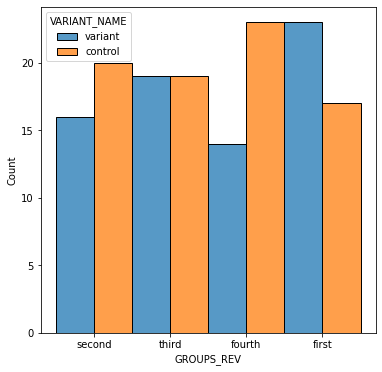

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(df.loc[(df['REVENUE'] > 0)],x ='GROUPS_REV',stat='count',hue = 'VARIANT_NAME',multiple="dodge",color = 'green')


На графике мы видим, что количество товаров из второй и четвертой группой уменьшилось, в третьей группе все осталось без именений,а вот в количество проданных товаров из первой группы значительно увеличилось

Проверим значимость таких результатов для каждой из групп также через критерий Хи-квадрат

* First
  - H0: В ходе изменений на сайте количество проданых товаров из первой ценовой категории не изменилось
  - H1: В ходе изменений на сайте количество проданых товаров из первой ценовой категории увеличилось

* Second
  - H0: В ходе изменений на сайте количество проданых товаров из второй ценовой категории не изменилось
  - H1: В ходе изменений на сайте количество проданых товаров из первой ценовой категории уменьшилось

* Third
  - H0: В ходе изменений на сайте количество проданых товаров из третьей ценовой категории не изменилось
  - H1: В ходе изменений на сайте количество проданых товаров из третьей ценовой категории изменилось

* Fourth
  - H0: В ходе изменений на сайте количество проданых товаров из четвертой ценовой категории не изменилось
  - H1: В ходе изменений на сайте количество проданых товаров из четвертой ценовой категории уменьшилось

Таблица сопряженности

In [ ]:
contingency_table_2 = pd.DataFrame({'_':['First','Second','Third','Fourht','Total'],
                                    'Control':[control_fr,control_sc,control_th,control_fo,control_buy],
                                    'Variant':[variant_fr,variant_sc,variant_th,variant_fo,variant_buy],
                                    'Total':[control_fr+variant_fr,control_sc+variant_sc,control_th+variant_th,control_fo+variant_fo,control_buy+variant_buy],
                                    })


In [ ]:
contingency_table_2.head()

,_,Control,Variant,Total
0,First,23,17,40
1,Second,16,20,36
2,Third,19,19,38
3,Fourht,14,23,37
4,Total,79,72,151


Ожидаемая частота = (сумма строк * сумма столбцов) / сумма таблицы


First

In [ ]:
# Ожидаемая частота купивших control
expected_per_control = (contingency_table_2['Total'][0] * contingency_table_2['Control'][4])/contingency_table_2['Total'][4]
# Ожидаемая частота купивших variant
expected_per_variant = (contingency_table_2['Total'][0] * contingency_table_2['Variant'][4])/contingency_table_2['Total'][4]
print(expected_per_control,expected_per_variant)

20.927152317880793 19.072847682119207


In [ ]:
stats.chisquare(f_obs=[contingency_table_2['Control'][0],contingency_table_2['Variant'][0]],
    f_exp=[expected_per_control,expected_per_variant])

Power_divergenceResult(statistic=0.43059511251758154, pvalue=0.5116970800160716)

Second

In [ ]:
# Ожидаемая частота купивших control
expected_per_control = (contingency_table_2['Total'][1] * contingency_table_2['Control'][4])/contingency_table_2['Total'][4]
# Ожидаемая частота купивших variant
expected_per_variant = (contingency_table_2['Total'][1] * contingency_table_2['Variant'][4])/contingency_table_2['Total'][4]
print(expected_per_control,expected_per_variant)
stats.chisquare(f_obs=[contingency_table_2['Control'][1],contingency_table_2['Variant'][1]],
    f_exp=[expected_per_control,expected_per_variant])

18.834437086092716 17.165562913907284


Power_divergenceResult(statistic=0.8945929051414291, pvalue=0.3442357015842661)

Third

In [ ]:
# Ожидаемая частота купивших control
expected_per_control = (contingency_table_2['Total'][2] * contingency_table_2['Control'][4])/contingency_table_2['Total'][4]
# Ожидаемая частота купивших variant
expected_per_variant = (contingency_table_2['Total'][2] * contingency_table_2['Variant'][4])/contingency_table_2['Total'][4]
print(expected_per_control,expected_per_variant)
stats.chisquare(f_obs=[contingency_table_2['Control'][2],contingency_table_2['Variant'][2]],
    f_exp=[expected_per_control,expected_per_variant])

19.880794701986755 18.119205298013245


Power_divergenceResult(statistic=0.08183895921237691, pvalue=0.7748206071147562)

Fourth

In [ ]:
# Ожидаемая частота купивших control
expected_per_control = (contingency_table_2['Total'][3] * contingency_table_2['Control'][4])/contingency_table_2['Total'][4]
# Ожидаемая частота купивших variant
expected_per_variant = (contingency_table_2['Total'][3] * contingency_table_2['Variant'][4])/contingency_table_2['Total'][4]
print(expected_per_control,expected_per_variant)
stats.chisquare(f_obs=[contingency_table_2['Control'][3],contingency_table_2['Variant'][3]],
    f_exp=[expected_per_control,expected_per_variant])

19.357615894039736 17.642384105960264


Power_divergenceResult(statistic=3.109823431025963, pvalue=0.07782139654409342)

Для степеней свободы 3 значение при p = 0.05 = 7.8

Отсюда Вывод: не одно из изменений не является статистически значимым => Эксперимент никак не повлиял на изменения в количестве покупок в разных ценовых категориях

# Результаты

Рекомендация для менеджера:

Т.к Средний чек уменьшился, конверсия осталась на прежнем уровне, а изменение количества покупок в пределах ценовой категории статистически не значимы то рекомендация может быть одна - признать эксперимент неудачным